In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])

a = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
b = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model
s = pd.DataFrame(data=1*1e-4, index=volumes.index, columns=volumes.columns)

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

np.random.seed(0)
noise=pd.DataFrame(index=returns.index, columns=returns.columns, 
                   data=0.1*np.random.randn(*returns.values.shape))
return_estimate= returns + noise
return_estimate.USDOLLAR = returns.USDOLLAR
alpha_model = cp.AlphaSource(return_estimate)

In [2]:
simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

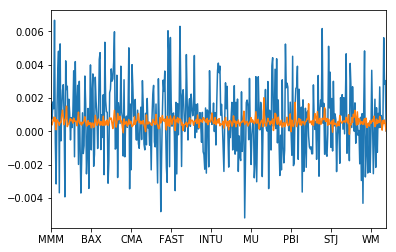

In [3]:
return_estimate.mean().plot()
returns.mean().plot()

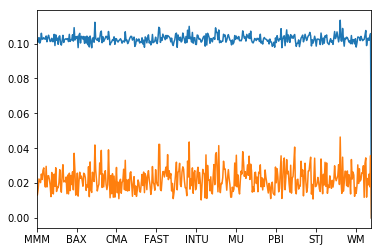

In [4]:
return_estimate.std().plot()
returns.std().plot()

In [5]:
return_estimate.min().min()

-0.5458176010204866

### Simulations

In [6]:
all_results={}

In [7]:
from cvx_portfolio.data import series_factor_model_covariance
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, variance_explained=.75,
                                                                           freq='MS',lookback_periods = 12)
risk_model = cp.FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

policies={}
gamma_risks=[ 30., 100., 300., 1000.]
gamma_tcosts=[30., 100., 300., 1000.] # only 0 1 60 70
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
                cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model, gamma_tcost*simulated_tcost],
                                                #simulated_hcost], 
                                [cp.LeverageLimit(3)])

## Simulations

In [8]:
import warnings
warnings.filterwarnings('ignore')
results=dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True)))

ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades
ERROR:root:The solver None failed. Defaulting to no trades


In [9]:
# temp
all_results.update(results)
results = all_results

result_df=pd.DataFrame()
for k in all_results:
    result_df.loc[k[0], k[1]] = all_results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))


In [10]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=used_returns.USDOLLAR)

result_df_used= result_df#[[0.,10., 15., 20.]]

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()    
table[r'Turnover']= \
    result_df_used.applymap(lambda res: res.turnover.mean()*100.*250.).unstack()



# # format index
# table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
#                       ["%g"%i for i in table.index.levels[1]]]))


table_print=pd.DataFrame(table,copy=True)
table_print=table_print.set_index(table_print.index.set_levels([["%g"%i for i in table_print.index.levels[0]],
                      ["%g"%i for i in table_print.index.levels[1]]]))
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{llllll}
\toprule
    &     & Excess return & Excess risk & Transaction costs &    Turnover \\
gamma_tcost & gamma_risk &               &             &                   &             \\
\midrule
30 & 30 &        19.98\% &      71.77\% &           451.48\% &  120092.42\% \\
    & 100 &         8.42\% &      55.16\% &           401.22\% &  122193.79\% \\
    & 300 &        -0.22\% &      39.89\% &           336.96\% &  122263.89\% \\
    & 1000 &        -4.89\% &      26.76\% &           262.36\% &  118223.67\% \\
100 & 30 &        28.24\% &      22.44\% &            69.48\% &   29993.40\% \\
    & 100 &        26.24\% &      20.05\% &            70.32\% &   31215.84\% \\
    & 300 &        26.87\% &      15.73\% &            70.06\% &   32545.06\% \\
    & 1000 &        25.55\% &       9.91\% &            62.77\% &   32257.93\% \\
300 & 30 &        17.40\% &      17.01\% &             3.36\% &    3175.33\% \\
    & 100 &        16.77\% &      15.88\% &             3.29\%

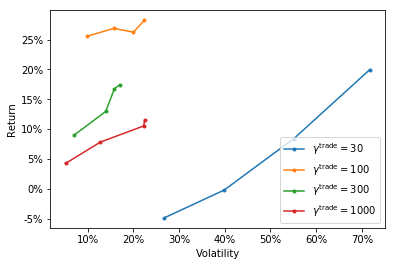

In [20]:
plt.figure(figsize=(6,4))
for gamma_tcost in table.index.levels[0][:]:
    x = table.loc[gamma_tcost]['Excess risk']
    y = table.loc[gamma_tcost]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Volatility')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig('spo_riskrewardfrontier.png')

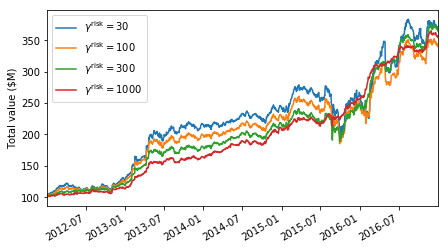

In [21]:
gamma_tcost=100#gamma_tcosts[2]
plt.figure(figsize=(7,4))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %g$'%i) for i in gamma_risks]
plt.legend(loc='upper left')# if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [13]:
sigmas.values[:,:-1]

array([[ 0.009321,  0.007476,  0.01122 , ...,  0.01904 ,  0.009664,
         0.01167 ],
       [ 0.006122,  0.01264 ,  0.01652 , ...,  0.026   ,  0.006868,
         0.005689],
       [ 0.005712,  0.0073  ,  0.007299, ...,  0.02171 ,  0.005861,
         0.003367],
       ..., 
       [ 0.003984,  0.008963,  0.008093, ...,  0.006502,  0.004903,
         0.009653],
       [ 0.00311 ,  0.005193,  0.00623 , ...,  0.00578 ,  0.003206,
         0.01157 ],
       [ 0.003329,  0.007975,  0.005765, ...,  0.007308,  0.006099,
         0.007158]])

(array([  1.05478100e+06,   1.97000000e+02,   3.30000000e+01,
          9.00000000e+00,   1.20000000e+01,   4.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.0171065 ,  0.03421299,  0.05131949,  0.06842598,
         0.08553248,  0.10263898,  0.11974547,  0.13685197,  0.15395846,
         0.17106496]),
 <a list of 10 Patch objects>)

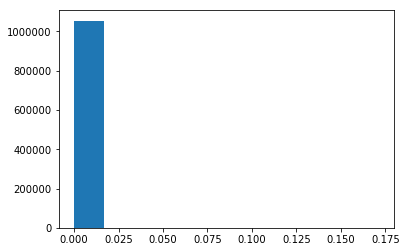

In [14]:
plt.hist(sigmas.values[:,:-1].flatten()**2)

In [15]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.279506,1.263188,1.026669,0.516143
100.0,0.153190,1.313718,1.059932,0.473930
300.0,-0.005531,1.715168,0.930027,0.611939
1000.0,-0.183357,2.589567,1.268232,0.819903


In [16]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.687775,0.808085,0.868707,0.667588
100.0,0.719751,0.797345,0.851627,0.686236
300.0,0.706229,0.734951,0.862642,0.698671
1000.0,0.745645,0.718936,0.843055,0.803817


In [17]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,865.220930,1016.570915,1092.833525,839.825733
100.0,905.447220,1003.060522,1071.347126,863.284986
300.0,888.435823,924.568609,1085.203116,878.928517
1000.0,938.021136,904.421386,1060.563449,1011.201573


In [18]:
# for i in range(4):
#     gamma_tcost = gamma_tcosts[i]
#     plt.figure(figsize=(10,5))
#     [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
#     plt.legend(loc='upper right' if i==0 else 'upper left')
#     plt.ylabel('portfolio value (\$M)')
#     plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
#     plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

In [ ]:
# for i in range(4):
#     gamma_tcost = gamma_tcosts[i]
#     plt.figure(figsize=(10,5))
#     [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
#     plt.legend(loc='upper right' if i==0 else 'upper left')
#     plt.ylabel('portfolio value (\$M)')
#     plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
#     plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

In [ ]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

In [ ]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

In [ ]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [ ]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')